In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
import binvox
import os
import json
import trimesh
import skimage
import random
from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import io
from deep_sdf import utils, metrics, plotting
import math
import pandas as pd


import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [5]:
plane_gt = "/mnt/hdd/ShapeNetCore.v2/02691156/12c82319147385e7ef0e1705c5c9e361/models/model_normalized.obj"
plane_recon = "examples/plane_ours/TensorBoard/ReconstructionsTrain/02691156_12c82319147385e7ef0e1705c5c9e361/train_mesh_epoch=2020.ply"
plane_recon = "examples/plane_ours/TensorBoard/ReconstructionsTrain/02691156_12c82319147385e7ef0e1705c5c9e361/train_mesh_epoch=120.ply"

In [6]:
gt_mesh = utils.as_mesh(trimesh.load_mesh(plane_gt))
recon_mesh = utils.as_mesh(trimesh.load_mesh(plane_recon))

In [7]:
metrics.compute_metric(gt_mesh, recon_mesh)

0.07700319746289094

In [15]:
metrics.compute_metric(trimesh.load_mesh(plane_gt), trimesh.load_mesh(plane_recon))


AttributeError: 'Scene' object has no attribute 'area_faces'

In [2]:
metrics.compute_metric(trimesh.load_mesh(plane_gt), trimesh.load_mesh(plane_recon))


NameError: name 'plane_gt' is not defined

In [4]:
for epoch in [200, 400, 600, 800, 1000]:
    print("EPOCH: ", epoch)
    get_recon_path = lambda class_id, shape_id: f"/home/shared/deepsdfcomp/searches/ffe_100_shapes/exp_0011_CodeLength=60_encoding_features=23_encoding_sigma=0.783/TensorBoard/ReconstructionsTrain/{class_id}_{shape_id}/epoch={epoch}.ply"
    get_gt_path = lambda class_id, shape_id: f"/mnt/hdd/ShapeNetCore.v2/{class_id}/{shape_id}/models/model_normalized.obj"

    reconstr_dirs = os.listdir("/home/shared/deepsdfcomp/searches/ffe_100_shapes/exp_0011_CodeLength=60_encoding_features=23_encoding_sigma=0.783/TensorBoard/ReconstructionsTrain")
    shapes = [dir_name.split("_") for dir_name in reconstr_dirs]

    cds = []
    for (class_id, shape_id) in shapes:
        gt_path = get_gt_path(class_id, shape_id)
        gt_mesh = utils.as_mesh(trimesh.load_mesh(gt_path))
        recon_path = get_recon_path(class_id, shape_id)
        recon_mesh = utils.as_mesh(trimesh.load_mesh(recon_path))
        cd = metrics.compute_metric(gt_mesh, recon_mesh, num_mesh_samples=30000)
        print(f"Shape {shape_id} from class {class_id} with CD={cd:.3f}")
        cds.append(cd)
    print(f"Avg CD={sum(cds)/len(cds):.4f}")

EPOCH:  200


TypeError: unsupported format string passed to tuple.__format__

In [5]:
gt_mesh = utils.as_mesh(trimesh.load_mesh(plane_gt))
recon_mesh = utils.as_mesh(trimesh.load_mesh(plane_recon))

[['02691156', '122963149f6a04272620819ddac40644'],
 ['02691156', '124062ccaeae95085e9e2656aff7dd5b'],
 ['02691156', '1628b65a9f3cd7c05e9e2656aff7dd5b'],
 ['02691156', '144070f63941362bd1810447902e2904'],
 ['02691156', '10cfc2090a2ade124c3a35cee92bb95b']]

In [3]:
metrics.compute_metric(gt_mesh, gt_mesh, num_mesh_samples=30000)

5.876217082101655e-06

In [5]:
cd, all_dists = metrics.compute_metric(recon_mesh, recon_mesh, num_mesh_samples=30000)

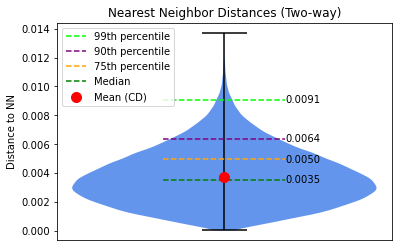

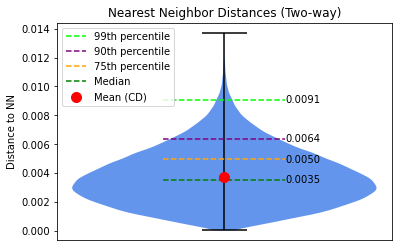

In [27]:
plotting.plot_dist_violin(all_dists)

In [16]:
print("Box")

box1 = trimesh.primitives.Box(extents=[1, 1, 1])
box2 = trimesh.primitives.Box(extents=[1, 1, 2])

num_mesh_samples = 60000
cd1, _ = metrics.compute_metric(box1, box1, num_mesh_samples=num_mesh_samples)
print("CD1: ", cd1)

num_mesh_samples_per_side = num_mesh_samples / 6
cd12_expected = 0 + (2 * num_mesh_samples_per_side * 0.5) / num_mesh_samples
cd12_expected *= 2      # two-way
print("CD12 expected: ", cd12_expected)

cd12, _ = metrics.compute_metric(box1, box2, num_mesh_samples=num_mesh_samples)
print("CD12: ", cd12)

Box
CD1:  6.345233230725315e-05
CD12 expected:  0.3333333333333333
CD12:  0.09682890734703407


In [15]:
print("Sphere")

sphere1 = trimesh.primitives.Sphere(radius=1)
sphere2 = trimesh.primitives.Sphere(radius=2)

num_mesh_samples = 60000
cd1, _ = metrics.compute_metric(sphere1, sphere1, num_mesh_samples=num_mesh_samples)
print("CD1: ", cd1)

cd12_expected = num_mesh_samples * 1 / num_mesh_samples
cd12_expected *= 2      # two-way
print("CD12 expected: ", cd12_expected)

cd12, _ = metrics.compute_metric(sphere1, sphere2, num_mesh_samples=num_mesh_samples)
print("CD12: ", cd12)

Sphere
CD1:  0.0001330898998968488
CD12 expected:  2.0
CD12:  1.9860454532156915


In [2]:
print("Cylinder")

cylinder1 = trimesh.primitives.Cylinder(radius=1, height=1)
cylinder2 = trimesh.primitives.Cylinder(radius=2, height=1)

num_mesh_samples = 60000
cd1, _ = metrics.compute_metric(cylinder1, cylinder1, num_mesh_samples=num_mesh_samples)
print("CD1: ", cd1)

get_side_surf_samples_frac = lambda r,h: (2*math.pi*r*h) / (2*math.pi*(r**2) + 2*math.pi*r*h)
# slight overapprox, since I neglect the "overhangs" at the top and bottom surfaces
cd12_expected = get_side_surf_samples_frac(1, 1) * num_mesh_samples * 1. / num_mesh_samples
cd12_expected *= 2      # two-way
print("CD12 expected: ", cd12_expected)

cd12, _ = metrics.compute_metric(cylinder1, cylinder2, num_mesh_samples=num_mesh_samples)
print("CD12: ", cd12)

Cylinder
CD1:  0.00013185724826310404
CD12 expected:  1.0
CD12:  0.5632856379423922


In [1]:
import pandas as pd
import ast

df = pd.read_csv("examples/planes/Evaluation/2000/chamfer.csv", delimiter=";")
df.head()

,shape,chamfer_dist,all_chamfer_dist
0,ShapeNetV2/02691156/d0456644386d9149ce593c35f7...,0.000021,[0.00130456 0.00328596 0.00146883 ... 0.002363...
1,ShapeNetV2/02691156/d068bfa97f8407e423fc69eefd...,0.000025,[0.00212525 0.00202687 0.00062582 ... 0.001355...
2,ShapeNetV2/02691156/d07277bc3c95a365bd46d022fd...,0.000017,[0.00200216 0.00134141 0.00063196 ... 0.003189...
3,ShapeNetV2/02691156/d1119217281b8475fe755e3418...,0.000025,[0.00221422 0.00178975 0.00263906 ... 0.002490...
4,ShapeNetV2/02691156/d15e3519a61c5bad86442c51e8...,0.000783,[0.0033731 0.00258659 0.00310682 ... 0.001885...


In [2]:
df = pd.read_csv("hparams_table.csv")

In [3]:
df

,dims,dropout,dropout_prob,norm_layers,latent_in,xyz_in_all,latent_dropout,weight_norm,nonlinearity,encoding_features,encoding_sigma,BestTrainLoss,BestTrainCD,BestTestCD
0,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.009552,-1.0,-1.0
1,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.008164,-1.0,-1.0
2,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.006965,-1.0,-1.0
3,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.007163,-1.0,-1.0
4,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.027466,-1.0,-1.0
5,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.027695,-1.0,-1.0
6,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.027588,-1.0,-1.0
7,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,1.0,1.0,sine,1.0,0.0,0.027405,-1.0,-1.0
8,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,0.0,1.0,sine,1.0,0.0,0.008778,-1.0,-1.0
9,"[256, 256, 256, 256, 256, 256, 256, 256]",[],0.0,[],[0],1.0,0.0,1.0,sine,1.0,0.0,0.009329,-1.0,-1.0


In [20]:
def plot_binary_vs_continuous(binary: str, continuous: str):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    df.plot(x=binary, y=continuous, kind="bar", ax=ax[0])
    df.groupby(binary).apply(lambda g: g.mean()).plot(y=continuous, kind="bar", ax=ax[1])

/tmp/ipykernel_1613479/2216380478.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby(binary).apply(lambda g: g.mean()).plot(y=continuous, kind="bar", ax=ax[1])


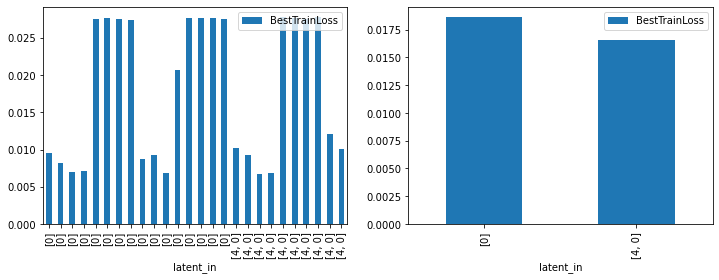

In [21]:
plot_binary_vs_continuous("latent_in", "BestTrainLoss")

/tmp/ipykernel_1613479/2216380478.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby(binary).apply(lambda g: g.mean()).plot(y=continuous, kind="bar", ax=ax[1])


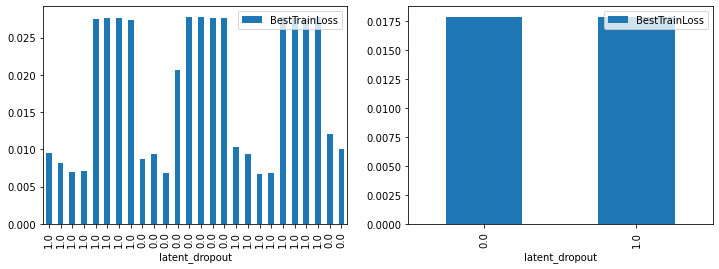

In [22]:
plot_binary_vs_continuous("latent_dropout", "BestTrainLoss")

In [ ]:
plot_binary_vs_continuous("latent_in", "BestTrainLoss")

/tmp/ipykernel_1613479/684658670.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby("latent_dropout").apply(lambda g: g.mean()).plot(y="BestTrainLoss", kind="bar", ax=ax[1])


<AxesSubplot:xlabel='latent_dropout'>

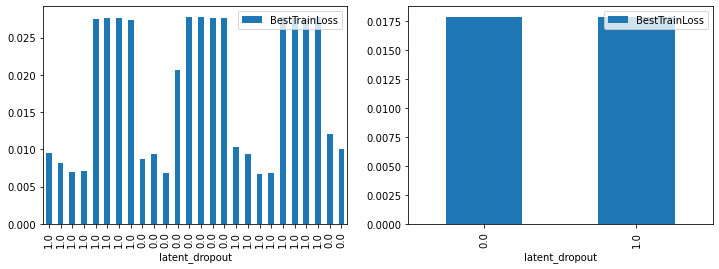